In [1]:
import requests
import json
import pandas as pd
import numpy as np
from functools import reduce
import datetime
import wbdata
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook" # use "pio.renderers" to see the default renderer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Blokis International Debt

## Objective
- Build time-series table with debt over time for a selection of countries. 
- Metric is called "Total External debt stocks" here: https://datatopics.worldbank.org/debt/ids/countryanalytical/ARG
- Data source: https://worldbank.github.io/debt-data/api-guide/ids-api-guide-python-1.html
- Source name: "International Debt Statistics", id:6
- Indicator name: "External debt stocks, total (DOD, current US$)", code: "DT.DOD.DECT.CD"
- Country selection: "Low & middle income" (LMY)
- World Bank Data API docs: https://wbdata.readthedocs.io/en/latest/wbdata_library.html

### Check data coordinates

In [3]:
# Make sure source exists
wbdata.get_source(source_id=6)

  id  name
----  -----------------------------
   6  International Debt Statistics

In [4]:
# Make sure indicator exists in source
ind = wbdata.get_indicator(source=6)
for i in ind:
    if i["id"] == "DT.DOD.DECT.CD":
        print("Found: "+ (str(i)))

Found: {'id': 'DT.DOD.DECT.CD', 'name': 'External debt stocks, total (DOD, current US$)', 'unit': '', 'source': {'id': '6', 'value': 'International Debt Statistics'}, 'sourceNote': 'Total external debt is debt owed to nonresidents repayable in currency, goods, or services. Total external debt is the sum of public, publicly guaranteed, and private nonguaranteed long-term debt, use of IMF credit, and short-term debt. Short-term debt includes all debt having an original maturity of one year or less and interest in arrears on long-term debt. Data are in current U.S. dollars.', 'sourceOrganization': 'World Bank, International Debt Statistics.', 'topics': [{'id': '3', 'value': 'Economy & Growth'}, {'id': '20', 'value': 'External Debt'}]}


In [5]:
# Print all selected countries
country_list = wbdata.get_country(incomelevel='LMY')
country_list

id    name
----  ------------------------------
AFG   Afghanistan
AGO   Angola
ALB   Albania
ARG   Argentina
ARM   Armenia
ASM   American Samoa
AZE   Azerbaijan
BDI   Burundi
BEN   Benin
BFA   Burkina Faso
BGD   Bangladesh
BGR   Bulgaria
BIH   Bosnia and Herzegovina
BLR   Belarus
BLZ   Belize
BOL   Bolivia
BRA   Brazil
BTN   Bhutan
BWA   Botswana
CAF   Central African Republic
CHN   China
CIV   Cote d'Ivoire
CMR   Cameroon
COD   Congo, Dem. Rep.
COG   Congo, Rep.
COL   Colombia
COM   Comoros
CPV   Cabo Verde
CRI   Costa Rica
CUB   Cuba
DJI   Djibouti
DMA   Dominica
DOM   Dominican Republic
DZA   Algeria
ECU   Ecuador
EGY   Egypt, Arab Rep.
ERI   Eritrea
ETH   Ethiopia
FJI   Fiji
FSM   Micronesia, Fed. Sts.
GAB   Gabon
GEO   Georgia
GHA   Ghana
GIN   Guinea
GMB   Gambia, The
GNB   Guinea-Bissau
GNQ   Equatorial Guinea
GRD   Grenada
GTM   Guatemala
GUY   Guyana
HND   Honduras
HTI   Haiti
IDN   Indonesia
IND   India
IRN   Iran, Islamic Rep.
IRQ   Iraq
JAM   Jamaica
JOR   Jordan
KAZ   Kaza

## Get WB data
### Obs
- Here, I encountered the following error when specifying a source in the arguments, (source=6):
"RuntimeError: Got error 175 (Invalid format): The indicator was not found. It may have been deleted or archived."
- Time range is not required but I thought it maybe better not to leave rely on defaults

In [6]:
countries = [i['id'] for i in wbdata.get_country(incomelevel='LMY')]
countries

['AFG',
 'AGO',
 'ALB',
 'ARG',
 'ARM',
 'ASM',
 'AZE',
 'BDI',
 'BEN',
 'BFA',
 'BGD',
 'BGR',
 'BIH',
 'BLR',
 'BLZ',
 'BOL',
 'BRA',
 'BTN',
 'BWA',
 'CAF',
 'CHN',
 'CIV',
 'CMR',
 'COD',
 'COG',
 'COL',
 'COM',
 'CPV',
 'CRI',
 'CUB',
 'DJI',
 'DMA',
 'DOM',
 'DZA',
 'ECU',
 'EGY',
 'ERI',
 'ETH',
 'FJI',
 'FSM',
 'GAB',
 'GEO',
 'GHA',
 'GIN',
 'GMB',
 'GNB',
 'GNQ',
 'GRD',
 'GTM',
 'GUY',
 'HND',
 'HTI',
 'IDN',
 'IND',
 'IRN',
 'IRQ',
 'JAM',
 'JOR',
 'KAZ',
 'KEN',
 'KGZ',
 'KHM',
 'KIR',
 'LAO',
 'LBN',
 'LBR',
 'LBY',
 'LCA',
 'LKA',
 'LSO',
 'MAR',
 'MDA',
 'MDG',
 'MDV',
 'MEX',
 'MHL',
 'MKD',
 'MLI',
 'MMR',
 'MNE',
 'MNG',
 'MOZ',
 'MRT',
 'MUS',
 'MWI',
 'MYS',
 'NAM',
 'NER',
 'NGA',
 'NIC',
 'NPL',
 'PAK',
 'PAN',
 'PER',
 'PHL',
 'PNG',
 'PRK',
 'PRY',
 'PSE',
 'ROU',
 'RUS',
 'RWA',
 'SDN',
 'SEN',
 'SLB',
 'SLE',
 'SLV',
 'SOM',
 'SRB',
 'SSD',
 'STP',
 'SUR',
 'SWZ',
 'SYR',
 'TCD',
 'TGO',
 'THA',
 'TJK',
 'TKM',
 'TLS',
 'TON',
 'TUN',
 'TUR',
 'TUV',
 'TZA',


In [7]:
def get_wb_data():
    countries = [i['id'] for i in wbdata.get_country(incomelevel='LMY')]
    indicators = {"DT.DOD.DECT.CD":"TotalExternalDebtUSD"}
    timeSelection = (datetime.datetime(2009, 1, 1), datetime.datetime(2018, 12, 31))
    
    df = wbdata.get_dataframe(indicators,freq="M", country=countries, convert_date=True, keep_levels=False)   
    return df

In [8]:
wb_df = get_wb_data()
wb_df.head(10)

TotalExternalDebtUSD
country     date                            
Afghanistan 2021-01-01                   NaN
            2020-01-01          3.036369e+09
            2019-01-01          2.661686e+09
            2018-01-01          2.678760e+09
            2017-01-01          2.751987e+09
            2016-01-01          2.596050e+09
            2015-01-01          2.596917e+09
            2014-01-01          2.529865e+09
            2013-01-01          2.587775e+09
            2012-01-01          2.580632e+09

### Format dataframe

In [9]:
def format_wb_df(df):
    df_list = []
    for country_name in df.index.unique(level='country'):
        
        # get each country data as pd.Series from multindex df
        row = df.xs(country_name,level=0, axis=0)
        row = row.rename(columns = {'TotalExternalDebtUSD':country_name})
        df_list.append(row[country_name])

    # merge series into dataframe
    return pd.concat(df_list, axis=1)

In [10]:
final_df = format_wb_df(wb_df)
final_df

,Afghanistan,Angola,Albania,Argentina,Armenia,American Samoa,Azerbaijan,Burundi,Benin,Burkina Faso,Bangladesh,Bulgaria,Bosnia and Herzegovina,Belarus,Belize,Bolivia,Brazil,Bhutan,Botswana,Central African Republic,China,Cote d'Ivoire,Cameroon,"Congo, Dem. Rep.","Congo, Rep.",Colombia,Comoros,Cabo Verde,Costa Rica,Cuba,Djibouti,Dominica,Dominican Republic,Algeria,Ecuador,"Egypt, Arab Rep.",Eritrea,Ethiopia,Fiji,"Micronesia, Fed. Sts.",Gabon,Georgia,Ghana,Guinea,"Gambia, The",Guinea-Bissau,Equatorial Guinea,Grenada,Guatemala,Guyana,Honduras,Haiti,Indonesia,India,"Iran, Islamic Rep.",Iraq,Jamaica,Jordan,Kazakhstan,Kenya,Kyrgyz Republic,Cambodia,Kiribati,Lao PDR,Lebanon,Liberia,Libya,St. Lucia,Sri Lanka,Lesotho,Morocco,Moldova,Madagascar,Maldives,Mexico,Marshall Islands,North Macedonia,Mali,Myanmar,Montenegro,Mongolia,Mozambique,Mauritania,Mauritius,Malawi,Malaysia,Namibia,Niger,Nigeria,Nicaragua,Nepal,Pakistan,Panama,Peru,Philippines,Papua New Guinea,"Korea, Dem. People's Rep.",Paraguay,West Bank and Gaza,Romania,Russian Federation,Rwanda,Sudan,Senegal,Solomon Islands,Sierra Leone,El Salvador,Somalia,Serbia,South Sudan,Sao Tome and Principe,Suriname,Eswatini,Syrian Arab Republic,Chad,Togo,Thailand,Tajikistan,Turkmenistan,Timor-Leste,Tonga,Tunisia,Turkey,Tuvalu,Tanzania,Uganda,Ukraine,Uzbekistan,St. Vincent and the Grenadines,Vietnam,Vanuatu,Samoa,Kosovo,"Yemen, Rep.",South Africa,Zambia,Zimbabwe
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01,3.036369e+09,6.728679e+10,1.085924e+10,2.537601e+11,1.309386e+10,NaN,1.581192e+10,6.259853e+08,5.250480e+09,4.494782e+09,6.774904e+10,4.334740e+10,1.426349e+10,4.249122e+10,1.526004e+09,1.542107e+10,5.492343e+11,2.868980e+09,1.597428e+09,9.356300e+08,2.349389e+12,2.507269e+10,1.386390e+10,6.137246e+09,5.253135e+09,1.551718e+11,301131309.5,2.069786e+09,3.128763e+10,NaN,2.678724e+09,328975990.2,4.446774e+10,5.178216e+09,5.619055e+10,1.315797e+11,7.885374e+08,3.036441e+10,1.518014e+09,NaN,7.615876e+09,2.008896e+10,3.132308e+10,4.175377e+09,775654200.1,8.059425e+08,NaN,658742963.7,2.513610e+10,1.506687e+09,1.101662e+10,2.317684e+09,4.175317e+11,5.641790e+11,5.451188e+09,NaN,1.803459e+10,3.801610e+10,1.629744e+11,3.819365e+10,8.697096e+09,1.756206e+10,NaN,1.716414e+10,6.886542e+10,1.480599e+09,NaN,733837563.5,5.634195e+10,1.052218e+09,6.568295e+10,8.475903e+09,4.873178e+09,3.351713e+09,4.675119e+11,NaN,1.060667e+10,6.081078e+09,1.334814e+10,9.722713e+09,3.323621e+10,2.093232e+10,5.710105e+09,1.852748e+10,2.943282e+09,NaN,NaN,4.590696e+09,7.057053e+10,1.205045e+10,7.904918e+09,1.165055e+11,1.088662e+11,7.354921e+10,9.847978e+10,1.797100e+10,NaN,1.976337e+10,NaN,1.423897e+11,4.755182e+11,8.193367e+09,2.295353e+10,1.723862e+10,428927088.9,2.113502e+09,1.833371e+10,4.659652e+09,3.846709e+10,NaN,291188749.4,NaN,766084561.1,4.763248e+09,3.654297e+09,2.546423e+09,2.041466e+11,6.797818e+09,5.636042e+09,231800534.6,194304203.1,4.103810e+10,4.358894e+11,NaN,2.553781e+10,1.720677e+10,1.298991e+11,3.217441e+10,406295764.5,1.250453e+11,455667428.4,437296399.1,3.108498e+09,7.120836e+09,1.707666e+11,3.004589e+10,1.274066e+10
2019-01-01,2.661686e+09,6.444616e+10,9.556856e+09,2.817238e+11,1.188449e+10,NaN,1.584036e+10,5.938894e+08,3.877756e+09,3.686905e+09,5.709417e+10,4.050140e+10,1.323115e+10,4.073412e+10,1.377529e+09,1.430115e+10,5.686459e+11,2.703805e+09,1.56

### Plot a country's debt over time

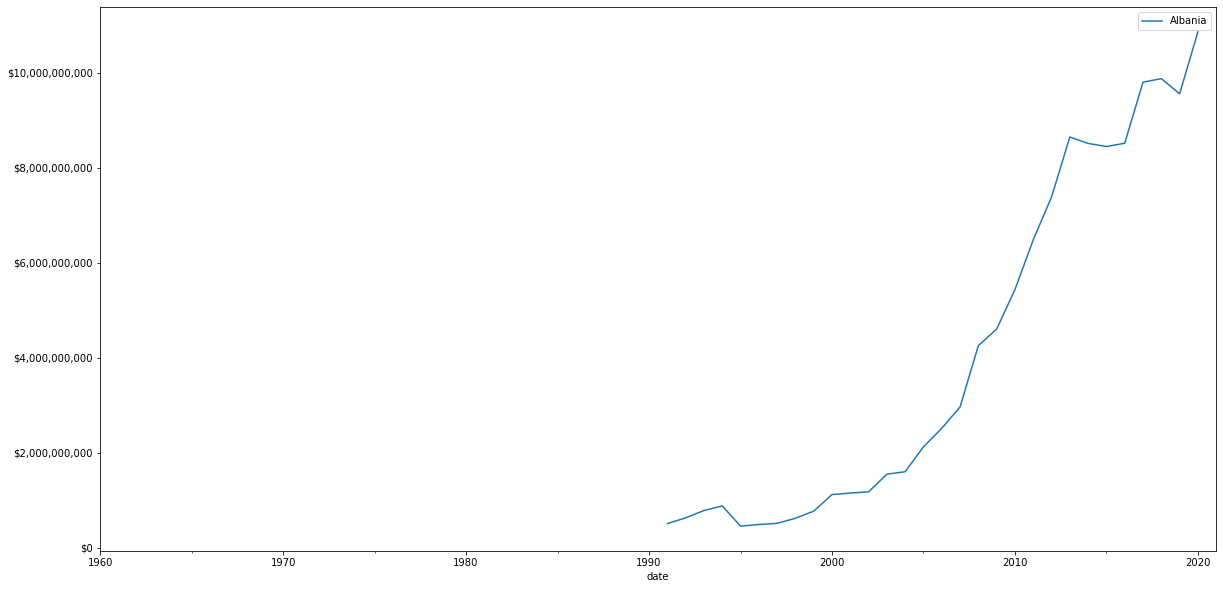

In [14]:
plot = final_df.plot(y=["Albania"],figsize=(20, 10))
func = lambda y, pos: f"${y:,.0f}"
plot.yaxis.set_major_formatter(func)
plt.show()

## Save dataset

In [15]:
#final_df.to_csv("debt_data.csv")

# Save `countries.json`

In [11]:
def countries_dict(country_list):
    """Returns json with countries and ids"""
    out = {}
    out_list = []
    for c in country_list:
        # out_list.append({"name":c['name'], "code":c['id'],"image_path":"./images/countries/ARG.ppm" })
        out_list.append({"name":c['name'], "code":c['id'],"image_path":"./images/countries/" + c['id'] + ".ppm" })
        out["countries"] = out_list
    return  out

In [12]:
country_dict = countries_dict(country_list)
country_dict

{'countries': [{'name': 'Afghanistan',
   'code': 'AFG',
   'image_path': './images/countries/AFG.ppm'},
  {'name': 'Angola',
   'code': 'AGO',
   'image_path': './images/countries/AGO.ppm'},
  {'name': 'Albania',
   'code': 'ALB',
   'image_path': './images/countries/ALB.ppm'},
  {'name': 'Argentina',
   'code': 'ARG',
   'image_path': './images/countries/ARG.ppm'},
  {'name': 'Armenia',
   'code': 'ARM',
   'image_path': './images/countries/ARM.ppm'},
  {'name': 'American Samoa',
   'code': 'ASM',
   'image_path': './images/countries/ASM.ppm'},
  {'name': 'Azerbaijan',
   'code': 'AZE',
   'image_path': './images/countries/AZE.ppm'},
  {'name': 'Burundi',
   'code': 'BDI',
   'image_path': './images/countries/BDI.ppm'},
  {'name': 'Benin', 'code': 'BEN', 'image_path': './images/countries/BEN.ppm'},
  {'name': 'Burkina Faso',
   'code': 'BFA',
   'image_path': './images/countries/BFA.ppm'},
  {'name': 'Bangladesh',
   'code': 'BGD',
   'image_path': './images/countries/BGD.ppm'},
  {'

In [13]:
with open("countries.json", "w") as fp:
    json.dump(country_dict, fp) 

# Save country flags


In [23]:
from PIL import Image
from io import BytesIO

In [31]:
def dl_flags(country_list):
    base_path = "flags/"
    base_url = "https://countryflagsapi.com/png/"
    for c in country_list:
        c_code = c['id']
        print("Downloading", c_code, c['name'])
        # for some godless reason
        if c_code == "XKX":
            url = base_url + "XXK"
        else:
            url = base_url + c_code
        image_name = base_path + c_code +'.ppm'
        r = requests.get(url)
        i = Image.open(BytesIO(r.content))
        i = i.resize((53, 32))
        i.save(image_name, "PNG")

dl_flags(country_list)